# HOPV Dataset

In [1]:

import os
import trainer
from detanet_model import *

import wandb
import random
random.seed(42)

batch_size = 64
epochs = 100
lr=5e-4
cutoff=5.0
num_block=3
num_features=128

finetune = False
# -------------------------------

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

HOPV_dataset = []
spec_data = []

# Load the dataset
HOPV_dataset = torch.load(os.path.join(data_dir, 'HOPV.pt'))
print(f"Number of graphs in the dataset: {len(HOPV_dataset)}")

print(f"Total dataset length: {len(HOPV_dataset)}")

ex1 = HOPV_dataset[0]
ex2 = HOPV_dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

for data in HOPV_dataset:
    data.y = torch.cat([data.real_ee, data.imag_ee], dim=0)
    data.x = data.spectra.repeat(len(data.z), 1)


ex1 = HOPV_dataset[0]
print("dataset[0] :", ex1, )





Number of graphs in the dataset: 347
Total dataset length: 347
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', z=[68], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[40], osc_strength=[40])
dataset[5] : Data(pos=[55, 3], idx='HOPV_5', dataset_name='HOPV', smiles='C#Cc1cc(OC)c(C#Cc2scc3nc(-c4ccccc4)c(-c4ccccc4)nc32)cc1OC', z=[55], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[40], osc_strength=[40])
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', z=[68], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], ima

In [2]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(HOPV_dataset)
train_frac = 0.9
split_index = int(train_frac * len(HOPV_dataset))

HOPV_train_datasets = HOPV_dataset[:split_index]
HOPV_val_datasets   = HOPV_dataset[split_index:]

print(len(HOPV_train_datasets))
print(len(HOPV_val_datasets))
for data in HOPV_val_datasets:
    print(data.idx)

312
35
HOPV_110
HOPV_79
HOPV_319
HOPV_174
HOPV_335
HOPV_81
HOPV_3
HOPV_142
HOPV_301
HOPV_229
HOPV_112
HOPV_214
HOPV_338
HOPV_101
HOPV_287
HOPV_13
HOPV_308
HOPV_258
HOPV_119
HOPV_111
HOPV_47
HOPV_15
HOPV_16
HOPV_216
HOPV_302
HOPV_44
HOPV_279
HOPV_52
HOPV_71
HOPV_114
HOPV_125
HOPV_140
HOPV_12
HOPV_57
HOPV_327


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_polarizability_elements(data_entry, model, out_dir="."):
    """<
    Assumptions:
      - data_entry.real -> shape [N, 3, 3]
      - data_entry.imag -> shape [N, 3, 3]
      - The model returns shape [N, 3, 6], where:
          [:, :, 0:3] => real part (3 columns -> [N, 3, 3])
          [:, :, 3:6] => imag part (3 columns -> [N, 3, 3])
    We then plot the 6 unique elements of a symmetric 3×3 matrix:
      (0,0)=xx, (0,1)=xy, (0,2)=xz, (1,1)=yy, (1,2)=yz, (2,2)=zz
    """


    mol_idx = data_entry.idx
    print(f"Mol idx = {mol_idx}")


    # 2) Convert GT real & imag to NumPy arrays of shape [N, 3, 3]
    real_list = np.array(data_entry.real)  # shape [N, 3, 3]
    imag_list = np.array(data_entry.imag)  # shape [N, 3, 3]
    N = real_list.shape[0]
    print(f"Number of frequency steps = {N}")

    # 3) Get predicted polarizabilities from the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    z = data_entry.z.to(device)
    pos = data_entry.pos.to(device)
    x= data_entry.x.to(device)

    with torch.no_grad():
        # pol_spec has shape [N, 3, 6]
        pol_spec = model(z=z, pos=pos, x_features=x).cpu().numpy()
        print("pol_spec", pol_spec.shape)


    # Split out real vs. imaginary from the last dimension
    # first 3 columns => real => shape [N, 3, 3]
    # last 3 columns  => imag => shape [N, 3, 3]

    pred_pol_real = pol_spec[0:62,...]
    pred_pol_imag = pol_spec[62:124,...]
    print("pred_pol_real", pred_pol_real.shape)
    print("pred_pol_imag", pred_pol_imag.shape)

    # 4) We only need the 6 unique elements of the symmetrical 3×3
    pairs = [(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]
    labels = ["xx", "xy", "xz", "yy", "yz", "zz"]


    # ----------------------------------
    # 0)  Collect global min / max once
    # ----------------------------------
    # gather ALL real‐part values (GT + pred)
    real_flat = np.hstack([
        real_list[:, i, j].ravel()          # GT real
        for (i, j) in pairs
    ] + [
        pred_pol_real[:, i, j].ravel()      # pred real
        for (i, j) in pairs
    ])
    rmin, rmax = real_flat.min(), real_flat.max()

    # gather ALL imag‐part values (GT + pred)
    imag_flat = np.hstack([
        imag_list[:, i, j].ravel()          # GT imag
        for (i, j) in pairs
    ] + [
        pred_pol_imag[:, i, j].ravel()      # pred imag
        for (i, j) in pairs
    ])
    imin, imax = imag_flat.min(), imag_flat.max()




    # ---------------- PLOT REAL PART ----------------
    fig_real, axes_real = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
    fig_real.suptitle(f"Polarizability (Real) - Mol idx={mol_idx}", fontsize=14)


    for subplot_idx, (i, j) in enumerate(pairs):
        row = subplot_idx // 2
        col = subplot_idx % 2
        ax = axes_real[row, col]

        # Ground-truth
        gt_vals = real_list[:, i, j]          # shape [N]
        # Predicted
        pred_vals = pred_pol_real[:, i, j]    # shape [N]

        ax.scatter(data_entry.freqs, gt_vals,  label="GT Real",  color="royalblue", alpha=0.5)
        ax.scatter(data_entry.freqs, pred_vals, label="Pred Real", color="tab:orange",  alpha=0.5)

        ax.set_title(f"{labels[subplot_idx]} (Real)")
        ax.set_xlabel("Frequency (eV)")
        ax.set_ylabel("Intensity")
        ax.set_ylim(rmin, rmax)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, f"polar_elements_real_{mol_idx}_{data_entry.dataset_name}.png"), dpi=300)
    plt.show()
    plt.close(fig_real)

    # ---------------- PLOT IMAG PART ----------------
    fig_imag, axes_imag = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
    fig_imag.suptitle(f"Polarizability (Imag) - Mol idx={mol_idx}", fontsize=14)


    for subplot_idx, (i, j) in enumerate(pairs):
        row = subplot_idx // 2
        col = subplot_idx % 2
        ax = axes_imag[row, col]

        # Ground-truth
        gt_vals = imag_list[:, i, j]          # shape [N]

        # Predicted
        pred_vals = pred_pol_imag[:, i, j]    # shape [N]

        ax.scatter(data_entry.freqs, gt_vals,  label="GT Imag",  color="royalblue", alpha= 0.5)
        ax.scatter(data_entry.freqs, pred_vals, label="Pred Imag", color="tab:orange",  alpha=0.5)

        ax.set_title(f"α_{labels[subplot_idx]} (Imag)")
        ax.set_xlabel("Frequency (eV)")
        ax.set_ylabel("Intensity")
        ax.set_ylim(imin, imax)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"polar_elements_imag_{mol_idx}_{data_entry.dataset_name}.png"), dpi=300)
    plt.show()
    plt.close(fig_imag)


In [4]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_HOPV = DetaNet(num_features=256,
                    act='swish',
                    maxl=3,
                    num_block=6, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=16,
                    rc=10.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='multi_tensor',
                    grad_type=None,
                    x_features=62,
                    device=device)


params='/home/maria/dyn-detanet/code/trained_param/NO_finetune_spectra_100epochs_8batchsize_0.0006lr_10cutoff_6numblock_256features_HOPV40_dataset.pth'
state_dict = torch.load(params)
model_HOPV.to(device)
model_HOPV.load_state_dict(state_dict=state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/home/maria/dyn-detanet/code/trained_param/NO_finetune_spectra_100epochs_8batchsize_0.0006lr_10cutoff_6numblock_256features_HOPV40_dataset.pth'

In [ ]:
for i in range(1):
    data_entry = HOPV_val_datasets[i]  # Assuming you want to plot the first entry
    plot_polarizability_elements(data_entry ,model_HOPV, out_dir="/home/maria/dyn-detanet/images")

Mol idx = HOPV_110


AttributeError: 'GlobalStorage' object has no attribute 'real'

# Smaller for thesis

In [5]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def approach_1_HOPV_model(device,params='trained_param/dynamic-polarizability/OPT_HOPV_NoSpectra0spectra80epochs_32batchsize_0.0005lr_4cutoff_4numblock_64features_8att_HOPV.pth'):
    state_dict = torch.load(params)
    model = DetaNet(num_features=64,
                    act='swish',
                    maxl=3,
                    num_block=4,
                    radial_type='trainable_bessel',
                    num_radial=128,
                    attention_head=8,
                    rc=4.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62),
                    irreps_out='124x2e',
                    summation=True,
                    norm=False,
                    out_type='multi_tensor',
                    grad_type=None,
                    x_features=0,
                    device=device)
    model.load_state_dict(state_dict=state_dict)
    return model

model_app1 = approach_1_HOPV_model(device)

In [6]:
# ───────────────────────────────────────────────────────────────────────────────
#  Polarizability plotter (application-1) — visuals cloned from trace plotter
#  (keeps the full 6-element tensor in a 1 × 6 grid; data logic unchanged)
# ───────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_polarizability_elements_app1(data_entry, model, out_dir="."):
    """
    Plot ground-truth (GT) and predicted polarizability spectra for one molecule.
    Styling (fonts, colours, legend box, etc.) is identical to the reference
    “trace” plotter; layout is 1 × 6 so every tensor element is displayed.
    """

    # ── GLOBAL STYLE ───────────────────────────────────────────────────────────
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update({
        "font.family":      "serif",
        "font.serif":       ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
        "font.size":        16,   # tick labels & default text
        "axes.titlesize":   16,   # per-panel titles
        "axes.labelsize":   24,   # global x / y labels (fig.text)
        "legend.fontsize":  22,
    })

    # ── 1.  Ground-truth tensors ───────────────────────────────────────────────
    mol_idx   = data_entry.idx
    real_list = np.asarray(data_entry.real_ee)          # [N, 3, 3]
    imag_list = np.asarray(data_entry.imag_ee)
    N         = real_list.shape[0]

    # ── 2.  Model prediction (unchanged) ───────────────────────────────────────
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device).eval()
    with torch.no_grad():
        pol_spec = model(
            z  = data_entry.z.to(device),
            pos= data_entry.pos.to(device),
        ).cpu().numpy()                                  # [N_real+N_imag, 3, 6]

    half            = pol_spec.shape[0] // 2
    pred_pol_real   = pol_spec[:half]
    pred_pol_imag   = pol_spec[half:]

    # ── 3.  Plot parameters ────────────────────────────────────────────────────
    pairs   = [(0, 0), (1, 1), (2, 2)]
    labels  = ["xx", "yy", "zz"]
    nrows, ncols = 1, 3

    gt_kwargs      = dict(marker="o", color="royalblue", s=25, alpha=0.6)
    gt_kwargs_imag = dict(marker="o", color="orange",   s=25, alpha=0.8)
    pred_kwargs    = dict(marker="^", color="black",    s=22, alpha=0.6)

    rmin = min(real_list.min(), pred_pol_real.min()) - 20
    rmax = max(real_list.max(), pred_pol_real.max()) + 20
    imin = min(imag_list.min(), pred_pol_imag.min()) - 20
    imax = max(imag_list.max(), pred_pol_imag.max()) + 20

    # ── 4.  Real-part figure ──────────────────────────────────────────────────
    fig_r, axes_r = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_r[idx]
        ax.scatter(data_entry.freqs[1:], real_list[1:, i, j],  label="GT",  **gt_kwargs)
        ax.scatter(data_entry.freqs[1:], pred_pol_real[1:, i, j], label="Prediction",
                   **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(rmin, rmax)
        ax.grid(True)

    fig_r.text(0.5, 0.04, "Frequency (eV)",
               ha="center", va="center", fontsize=22)
    fig_r.text(0.05, 0.5, "α-Real (a.u.)",
               ha="center", va="center", rotation="vertical", fontsize=22)

    handles, lbls = axes_r[0].get_legend_handles_labels()
    fig_r.legend(handles, lbls,
                 loc="upper right", bbox_to_anchor=(0.97, 0.84),
                 markerscale=3.0,
                 frameon=True, facecolor="white", edgecolor="0.70",
                 framealpha=0.8)

    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    os.makedirs(out_dir, exist_ok=True)
    fig_r.savefig(os.path.join(
        out_dir, f"polar_elements_real_{mol_idx}_{data_entry.dataset_name}.png"
    ), dpi=300)
    plt.show()
    plt.close(fig_r)

    # ── 5.  Imaginary-part figure ─────────────────────────────────────────────
    fig_i, axes_i = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_i[idx]
        ax.scatter(data_entry.freqs[1:], imag_list[1:, i, j],  label="GT",  **gt_kwargs_imag)
        ax.scatter(data_entry.freqs[1:], pred_pol_imag[1:, i, j], label="Prediction",
                   **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(imin, imax)
        ax.grid(True)

    fig_i.text(0.5, 0.04, "Frequency (eV)",
               ha="center", va="center", fontsize=22)
    fig_i.text(0.05, 0.5, "α-Imag (a.u.)",
               ha="center", va="center", rotation="vertical", fontsize=22)

    handles_i, lbls_i = axes_i[0].get_legend_handles_labels()
    fig_i.legend(handles_i, lbls_i,
                 loc="upper right", bbox_to_anchor=(0.97, 0.84),
                 markerscale=3.0,
                 frameon=True, facecolor="white", edgecolor="0.70",
                 framealpha=0.8)

    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    fig_i.savefig(os.path.join(
        out_dir, f"polar_elements_imag_{mol_idx}_{data_entry.dataset_name}.png"
    ), dpi=300)
    plt.show()
    plt.close(fig_i)


data_emtry Data(pos=[71, 3], idx='HOPV_110', dataset_name='HOPV', smiles='COc1ccc(N(c2ccc(OC)cc2)c2ccc(-c3cc4c(s3)-c3sc(C=C(C#N)C(=O)O)cc3C4(C)C)cc2)cc1', z=[71], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[40], osc_strength=[40], y=[124, 3, 3], x=[71, 62])


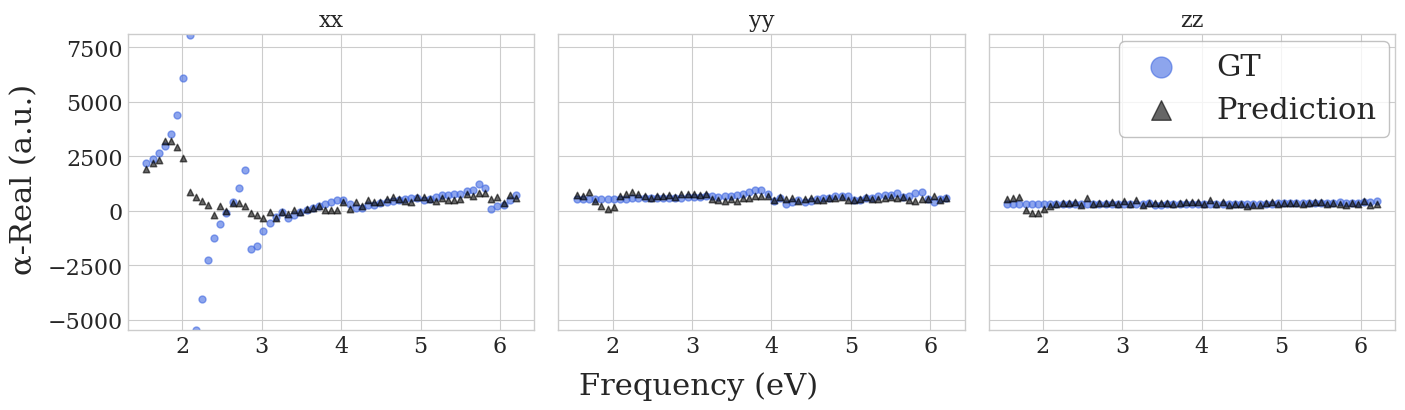

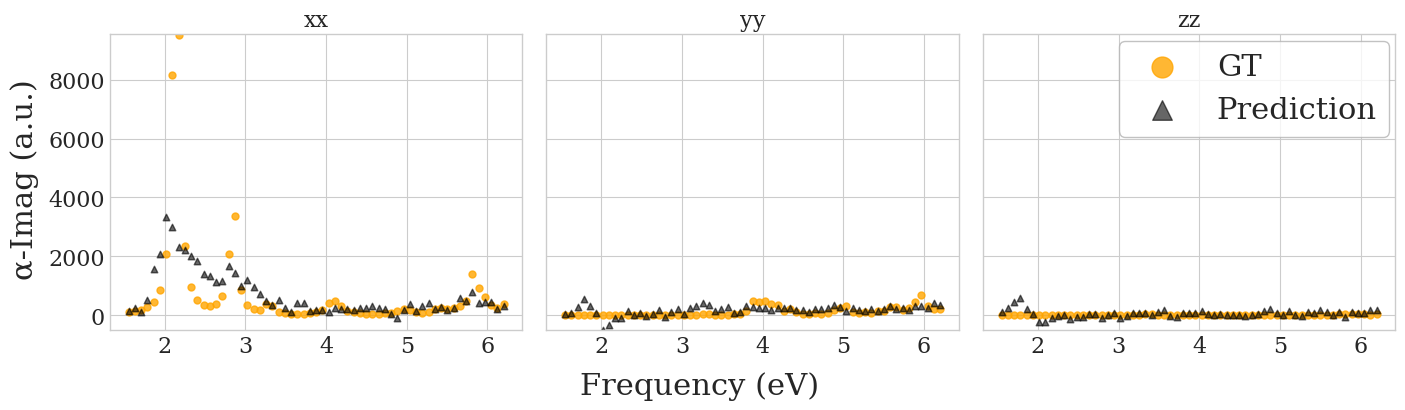

In [7]:
for i in range(1):
    data_entry = HOPV_val_datasets[i]  # Assuming you want to plot the first entry
    print("data_emtry", data_entry)
    
    plot_polarizability_elements_app1(data_entry ,model_app1, out_dir="/home/maria/dyn-detanet/images")

Flattened samples (true) : 39060
Flattened samples (pred) : 39060


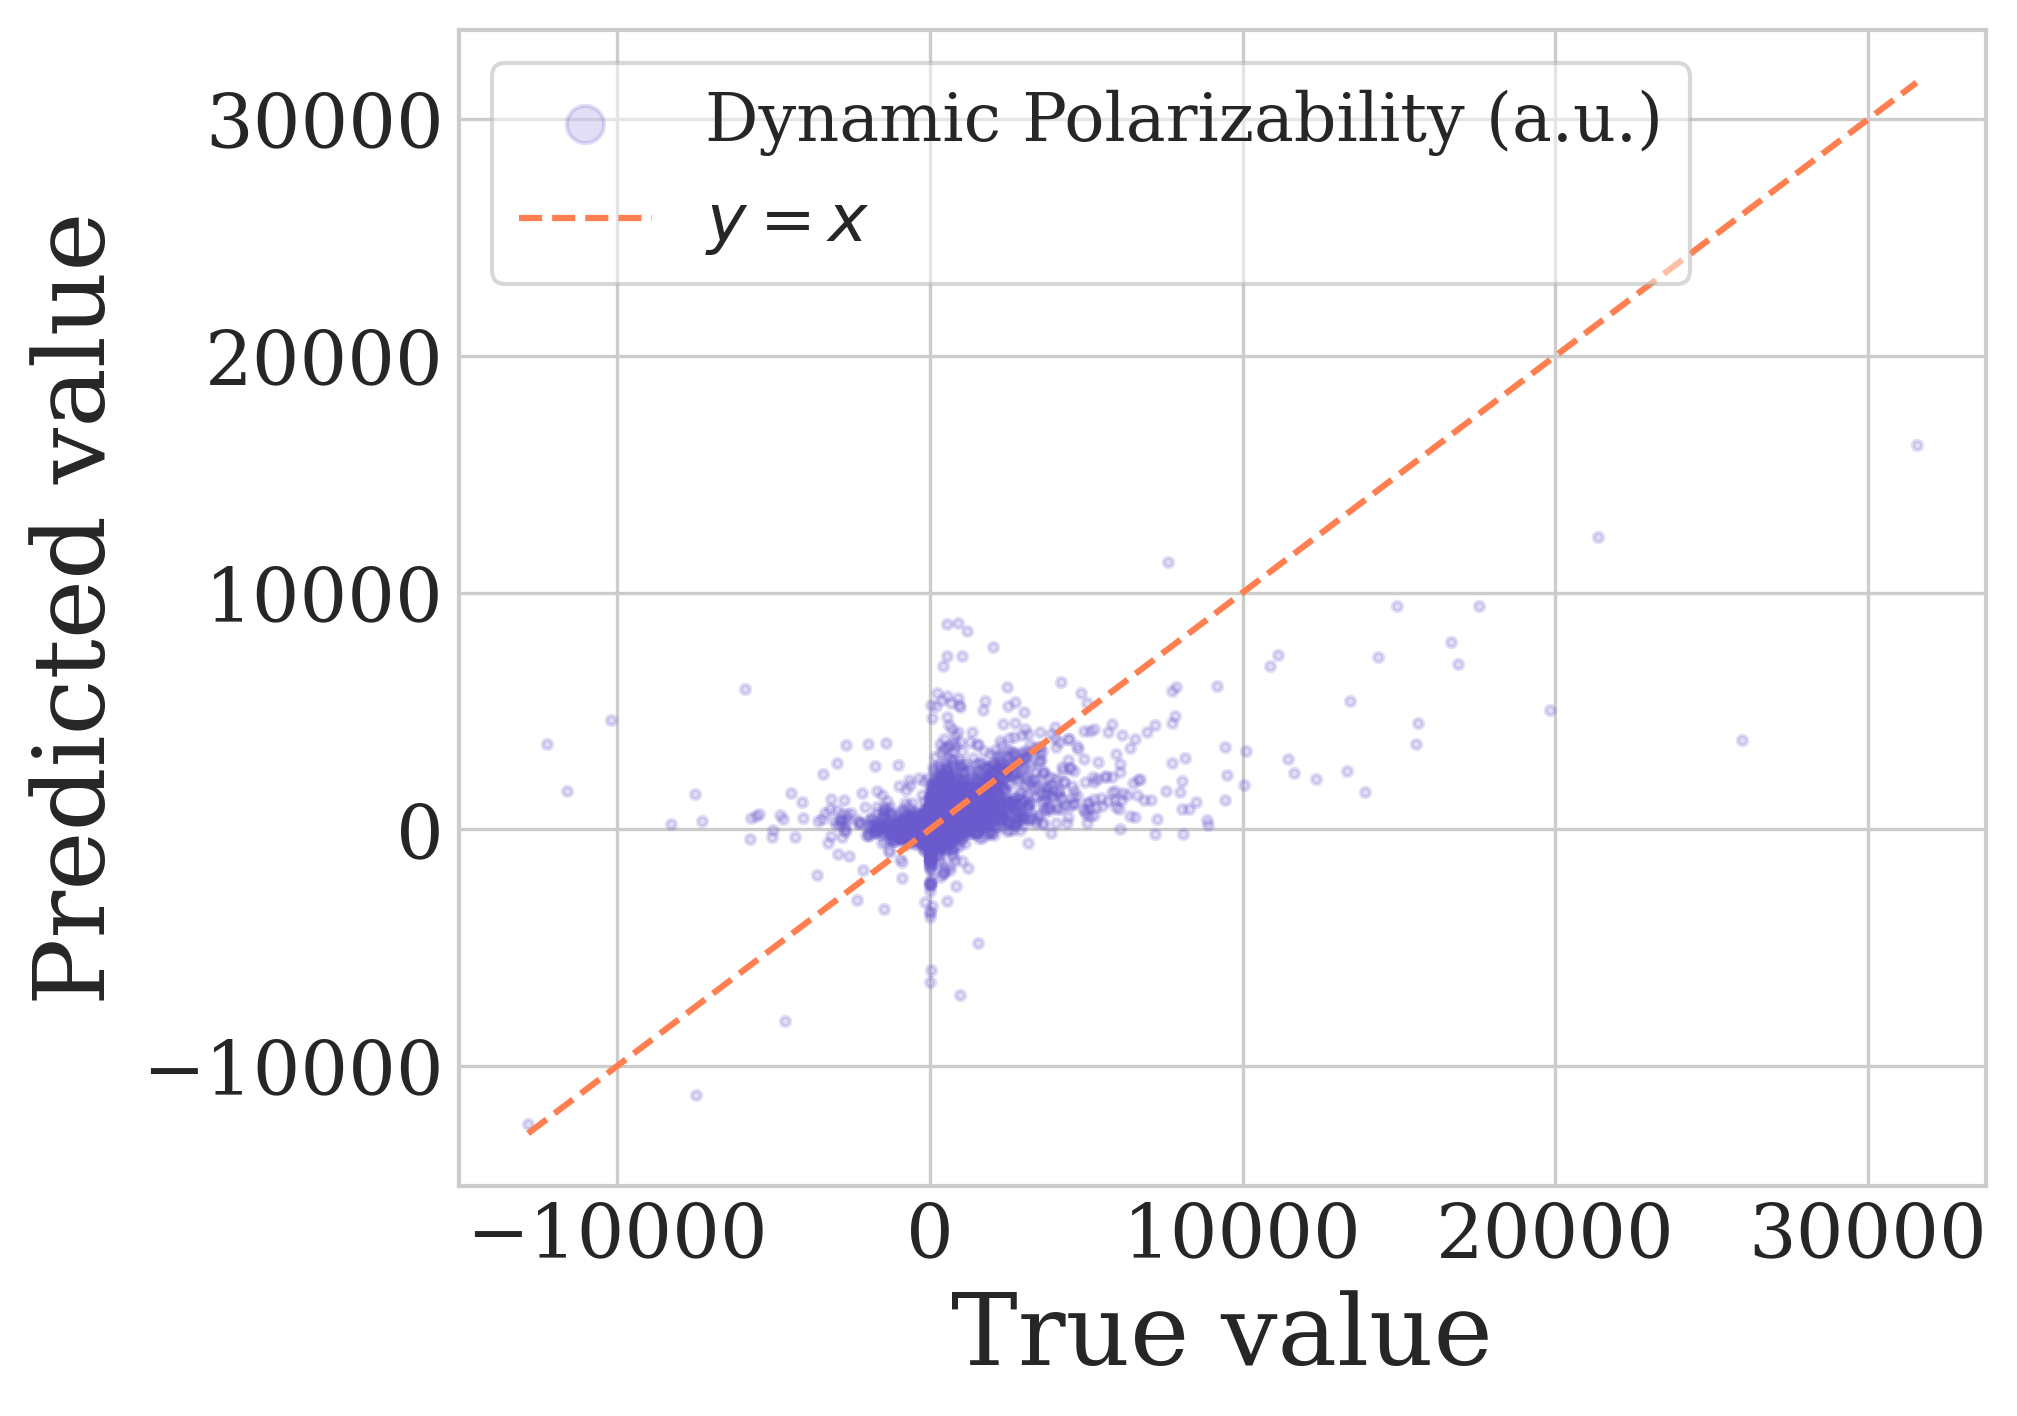

In [9]:
# ───────────────────────────────────────────────────────────────────────────────
#  Validation-set scatter plot : predicted vs. true  (HOPV, app-1 model)
#  – visuals cloned 1-for-1 from the reference “dynamic polarizability” plot –
# ───────────────────────────────────────────────────────────────────────────────
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from detanet_model import R2
from sklearn.metrics import r2_score, mean_absolute_error

# ══════════════════════════════════════════════════════════════════════════════
# 0.  Global style & fonts  — apply *before* creating any figure
# ══════════════════════════════════════════════════════════════════════════════
plt.style.use("seaborn-v0_8-whitegrid")        # same seaborn theme
plt.rcParams.update({
    "font.family":      "serif",
    "font.serif":       ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,   # base text size
    "axes.labelsize":   24,   # x / y axis labels
    "axes.titlesize":   18,
    "xtick.labelsize":  18,
    "ytick.labelsize":  18,
    "legend.fontsize":  16,
})

# ══════════════════════════════════════════════════════════════════════════════
# 1.  Collect ground-truth and predictions  (data logic unchanged)
# ══════════════════════════════════════════════════════════════════════════════
val_loader = DataLoader(HOPV_val_datasets, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model_app1.to(device).eval()

true_vals, pred_vals = [], []

with torch.no_grad():
    for batch in val_loader:
        true_vals.append(batch.y.cpu().view(-1))   # flatten GT

        pred = model(z=batch.z.to(device),
                     pos=batch.pos.to(device))

        pred_flat = pred.cpu().view(-1) if isinstance(pred, torch.Tensor) \
                   else torch.tensor(pred).view(-1)
        pred_vals.append(pred_flat)

true_vals = torch.cat(true_vals).numpy()
pred_vals = torch.cat(pred_vals).numpy()

print("Flattened samples (true) :", true_vals.size)
print("Flattened samples (pred) :", pred_vals.size)

# ══════════════════════════════════════════════════════════════════════════════
# 2.  Scatter plot — visuals exactly match reference
# ══════════════════════════════════════════════════════════════════════════════
plt.figure(figsize=(7, 5), dpi=300)

plt.scatter(true_vals, pred_vals,
            c="slateblue", s=5, alpha=0.2,
            label="Dynamic Polarizability (a.u.)")

vmin, vmax = min(true_vals.min(), pred_vals.min()), max(true_vals.max(),
                                                        pred_vals.max())
plt.plot([vmin, vmax], [vmin, vmax],
         "--", color="coral", label="$y=x$")

plt.xlabel("True value")           # sizes inherited from rcParams
plt.ylabel("Predicted value")

plt.legend(frameon=True,
           facecolor="white",
           edgecolor="0.7",
           framealpha=0.5,
           markerscale=4.0)         # enlarged legend symbols

plt.grid(True)
plt.tight_layout()
plt.show()
